In [1]:
import numpy as np 
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import zipfile
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
import keras.backend as K
 
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [2]:
root = '/content/gdrive/My Drive/'
folder = '/content/gdrive/My Drive/cats_and_dogs/test/'

In [ ]:
vgg16 = VGG16(include_top=False, weights='imagenet') 
vgg16.trainable = False

In [ ]:
#img_path = os.path.join(folder, '21.jpg') #dog image

In [ ]:
#Here the first eight layers to be activated are chosen:
layer_outputs = [layer.output for layer in vgg16.layers][:8]

In [ ]:
#A partial model is construced from the inputs of the convnet and their corresponding layer outputs:
activation_model = keras.models.Model(inputs = vgg16.input, outputs = layer_outputs)

In [ ]:
#activation output of the given image
activations = activation_model.predict(img_tensor)

In [ ]:
#observe the output of a given layer:
first_layer_activation = activations[3]

In [ ]:
plt.matshow(first_layer_activation[0,:,:,5], cmap='viridis')
plt.show()

In [ ]:
layer_name = 'block3_conv1'
filter_index = 0

layer_output = vgg16.get_layer(layer_name).output

In [ ]:
input_img_data = np.random.random((1,150,150,3))*20+128

In [ ]:
#activation model of a single layer filter:
model = keras.models.Model(inputs = vgg16.input, outputs = layer_output)

In [ ]:
#gradient ascent optimization for filter visualization:
step = 1.0
for i in range(40):
  with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(input)
    loss = K.mean(model(input)[:,:,:,filter_index])
  grads = tape.gradient(loss, input)[0]
  grads /= (K.square(K.mean(K.square(grads))) + 1e-5)
  input += grads*step

In [3]:
inception3 = InceptionV3(weights='imagenet', include_top=False)
inception3.trainable = False

87916544/87910968 [==============================] - 0s 0us/step


In [37]:
z = 100*np.random.rand(1,4)/4
x1, x2, x3, x4 = z[0]
print(z[0])

[19.09825754 17.42782502 13.91376513 17.68367284]


In [38]:
#for inception:
layer_contributions = {
    'mixed2': x1,
    'mixed3': x2,
    'mixed5': x3,
    'mixed10': x4
}

In [ ]:
#for vgg16:
layer_contributions = {
    'block2_conv2': 0.2,
    'block5_conv1': 0.3,
    'block5_conv2': 0.3,
    'block5_conv3': 3.5
}

In [39]:
#gradient ascent optimization:
def SGA(image, convnet, iterations, step, max_loss):
  img = tf.convert_to_tensor(image) #preprocess(img_path)
  
  layer_list = [(layer.name, layer) for layer in convnet.layers]
  layer_dict = dict(layer_list)
 
  for i in range(iterations):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
      tape.watch(img)
      for layer_name in layer_contributions:
        loss = 0
        coeff = layer_contributions[layer_name]
        activation = layer_dict[layer_name].output
        model = Model(inputs = convnet.input, outputs = activation)
 
        scaling = K.prod(K.cast(K.shape(model(img)), 'float32'))
        loss = loss + coeff*K.sum(K.square(model(img)[:, 2:-2, 2:-2, :]))/scaling
      
    grads = tape.gradient(loss, img)[0]
    grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)
    if max_loss is not None and loss > max_loss:
      break
    img += grads*step
 
  return img

In [10]:
#preprocessing function from the given path:
def preprocess(img_path):
  img = image.load_img(img_path)#, target_size=(150,150))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)/255
  input = tf.convert_to_tensor(img_tensor)
 
  return input

In [11]:
#resize image:
def resize_img(img, size):
  img = np.copy(img)
  factors = (1, float(size[0])/img.shape[1], float(size[1])/img.shape[2], 1)
 
  return scipy.ndimage.zoom(img, factors, order=1)

In [12]:
#save image as .png:
target = '/content/gdrive/My Drive/'
def save_img(img, fname):
  pil_image = deprocess_image(np.copy(img))
 
  return image.save_img(fname, pil_image)

In [13]:
#convert tensors to images:
def deprocess_image(x):
  squeezed = tf.squeeze(x).numpy()
  img = np.clip(squeezed, 0, 255)
  #array_img = image.array_to_img(squeezed)
 
  return img

In [40]:
#Dream parameters:
step = 0.01
num_octave = 3
octave_scale = 2.0
iterations = 20
max_loss = 10
 
#image preprocessing and shape extraction:
img_path = os.path.join(root, 'landscape4.jpeg') #---> custom image 
 
img = preprocess(img_path=img_path)
original_shape = img.shape[1:3] #tensor of shape (150,150)
succesive_shapes = [original_shape]
 
for i in range(1, num_octave):
  shape = tuple([dim//num_octave**i for dim in original_shape])
  succesive_shapes.append(shape)
 
succesive_shapes = succesive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, succesive_shapes[0])

In [41]:
#DeepDream Implementation:
for shape in succesive_shapes:
  print('Processing image shape', shape)
  img = resize_img(img, shape)
  img = SGA(img, convnet=inception3, iterations=iterations, step=step, max_loss=max_loss)
  upscaled_shrunk_original_image = resize_img(shrunk_original_img, shape)
  same_size_original = resize_img(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_image
  
  img += lost_detail
  shrunk_original_img = resize_img(original_img, shape)

Processing image shape (177, 100)
Processing image shape (533, 300)
Processing image shape (1600, 900)


In [42]:
#this is just a temporary fix to save and plot better quality images: 
x = tf.squeeze(img).numpy()*255
x = np.clip(x, 0, 255)/255

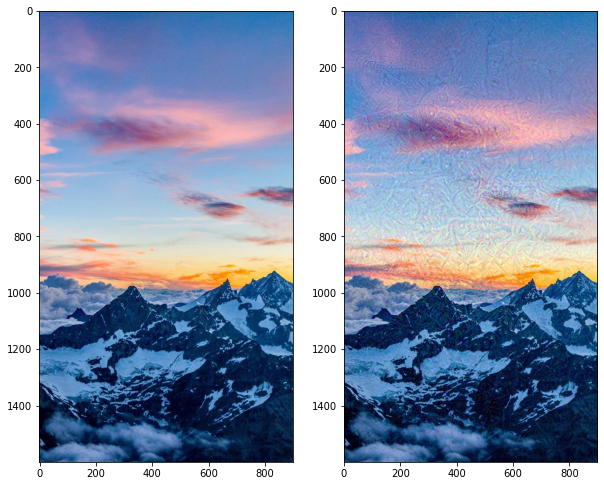

In [43]:
#plot comparisson of images:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,12))
ax2.imshow(x)
ax1.imshow(deprocess_image(original_img))
plt.show()

In [ ]:
#improved line to save high quality dream picture:
image.save_img(target+'landscapeDream4.png',x)

In [49]:
inception3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________